# A Look at Heart Disease Prediction

In [1]:
#Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import missingno as msgn

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [2]:
#Import data
data_directory = "../Downloads"
raw_data = pd.read_csv(f"{data_directory}/data_challenge.csv")

### EDA

We start by checking the type of data we have, how much data we have, and making sure there are no missing values.

In [3]:
raw_data.head()

,age,gender,chest_pain,restbp,cholestoral,high_fbs,EKG,thalachmax,angina_exercise,oldpeakST,slope,flouroscopy,thal,response
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
raw_data.shape

(303, 14)

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age                303 non-null int64
gender             303 non-null int64
chest_pain         303 non-null int64
restbp             303 non-null int64
cholestoral        303 non-null int64
high_fbs           303 non-null int64
EKG                303 non-null int64
thalachmax         303 non-null int64
angina_exercise    303 non-null int64
oldpeakST          303 non-null float64
slope              303 non-null int64
flouroscopy        303 non-null int64
thal               303 non-null int64
response           303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


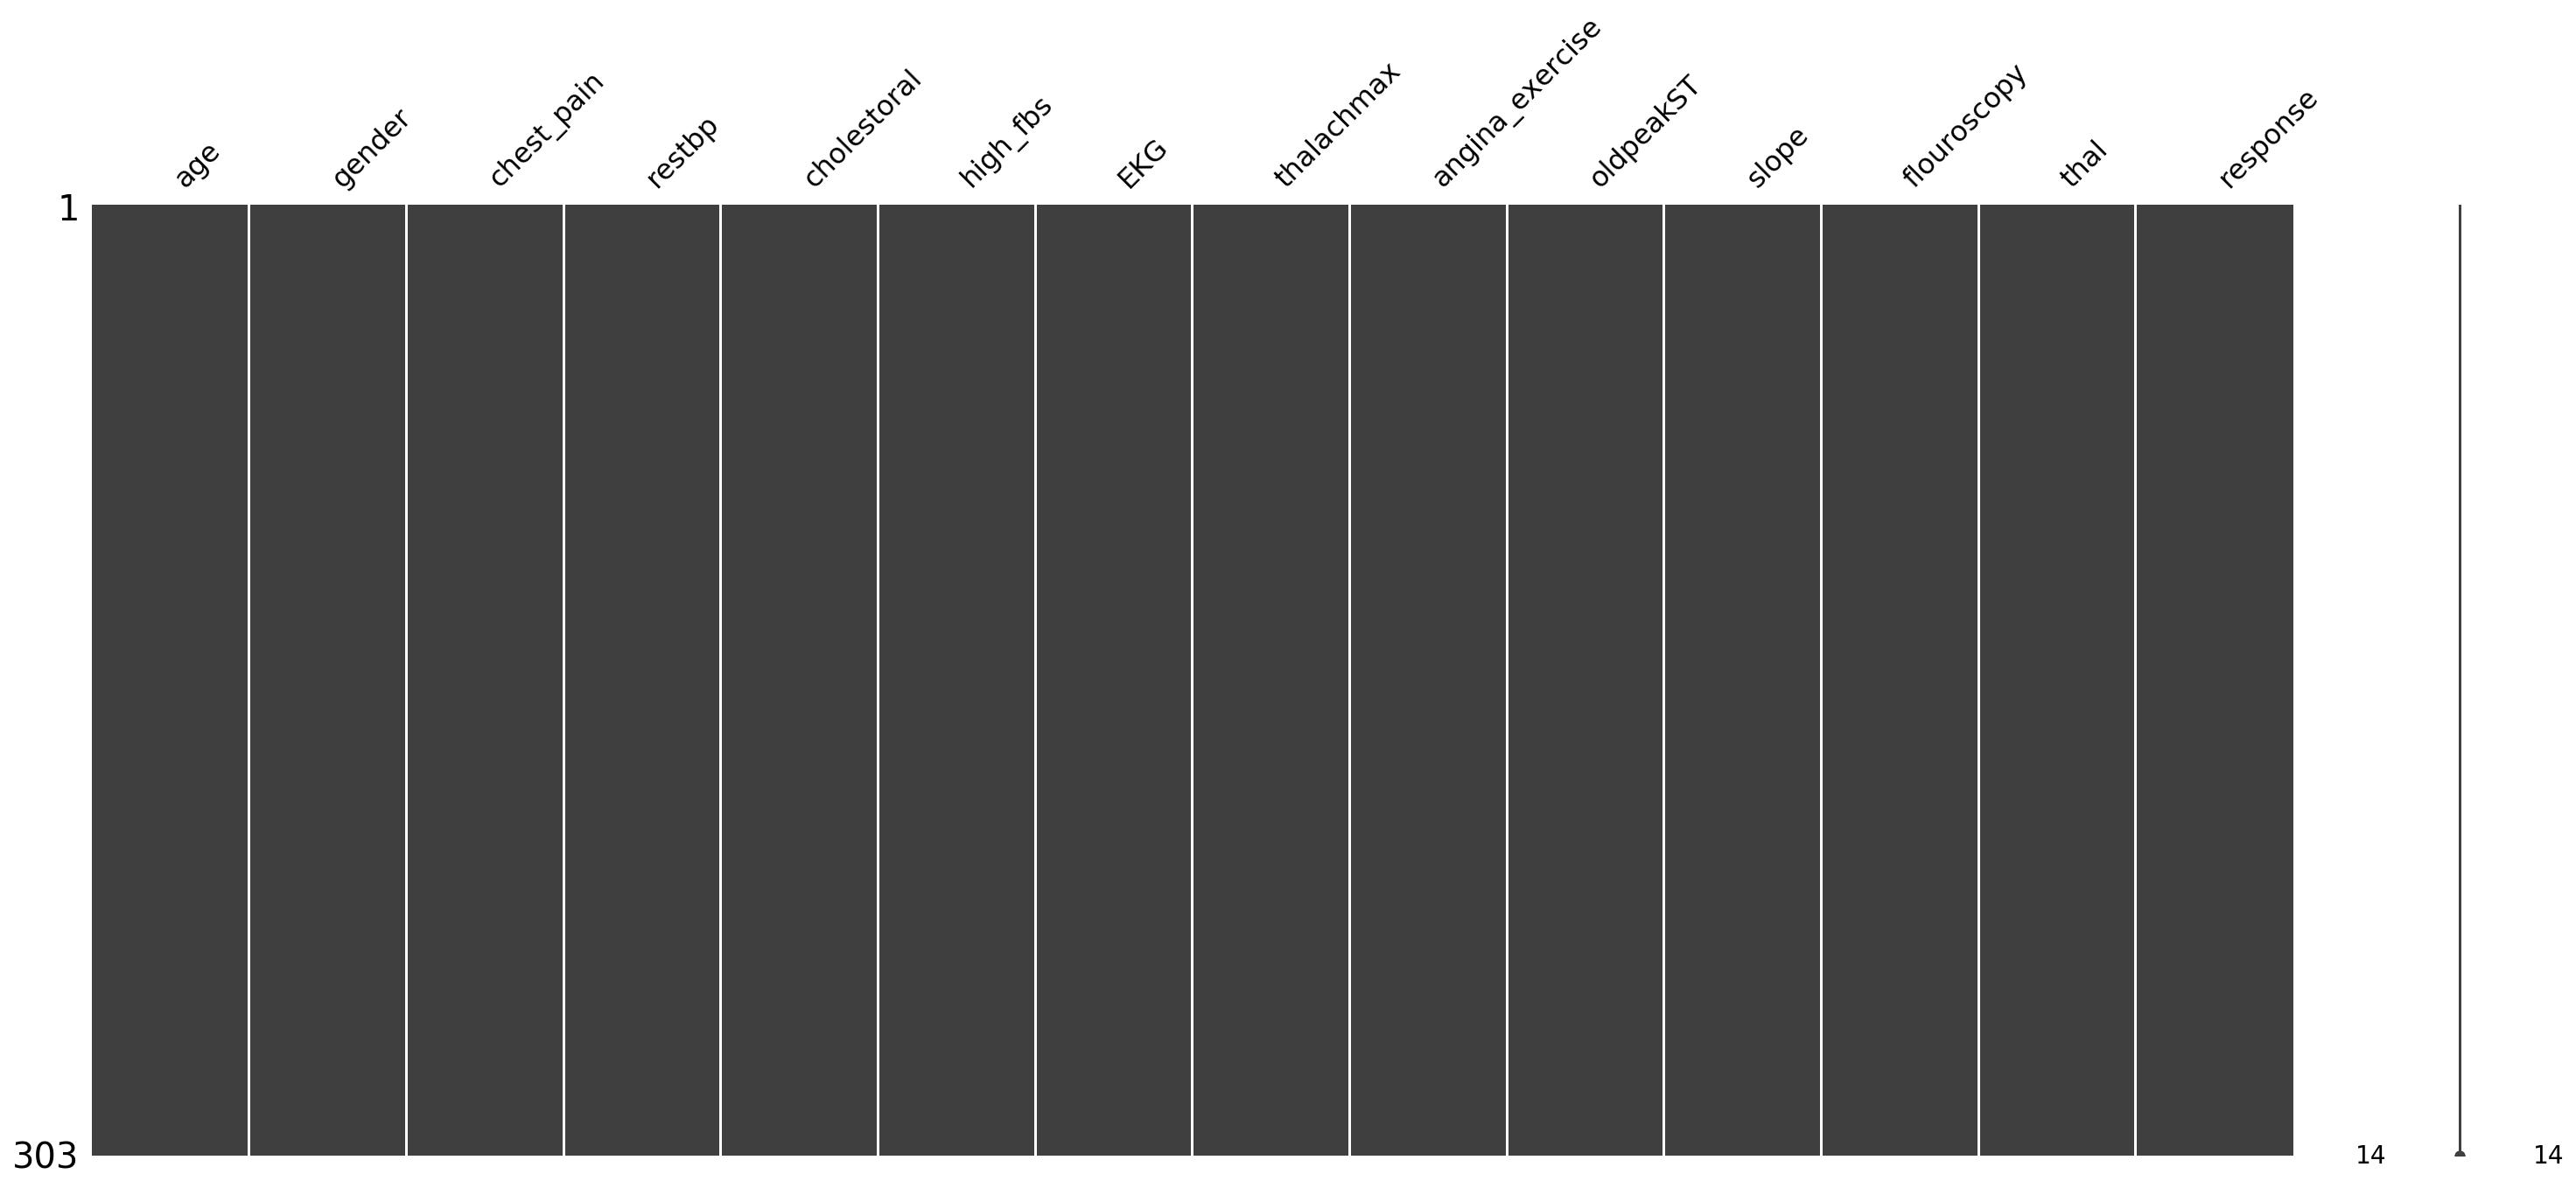

In [6]:
msgn.matrix(raw_data)

Here, we look at the mean for each feature for the groups with and without heart disease. We then proceed to look at the heatmap and pair plots. These figures will give us an idea of what the data looks like.

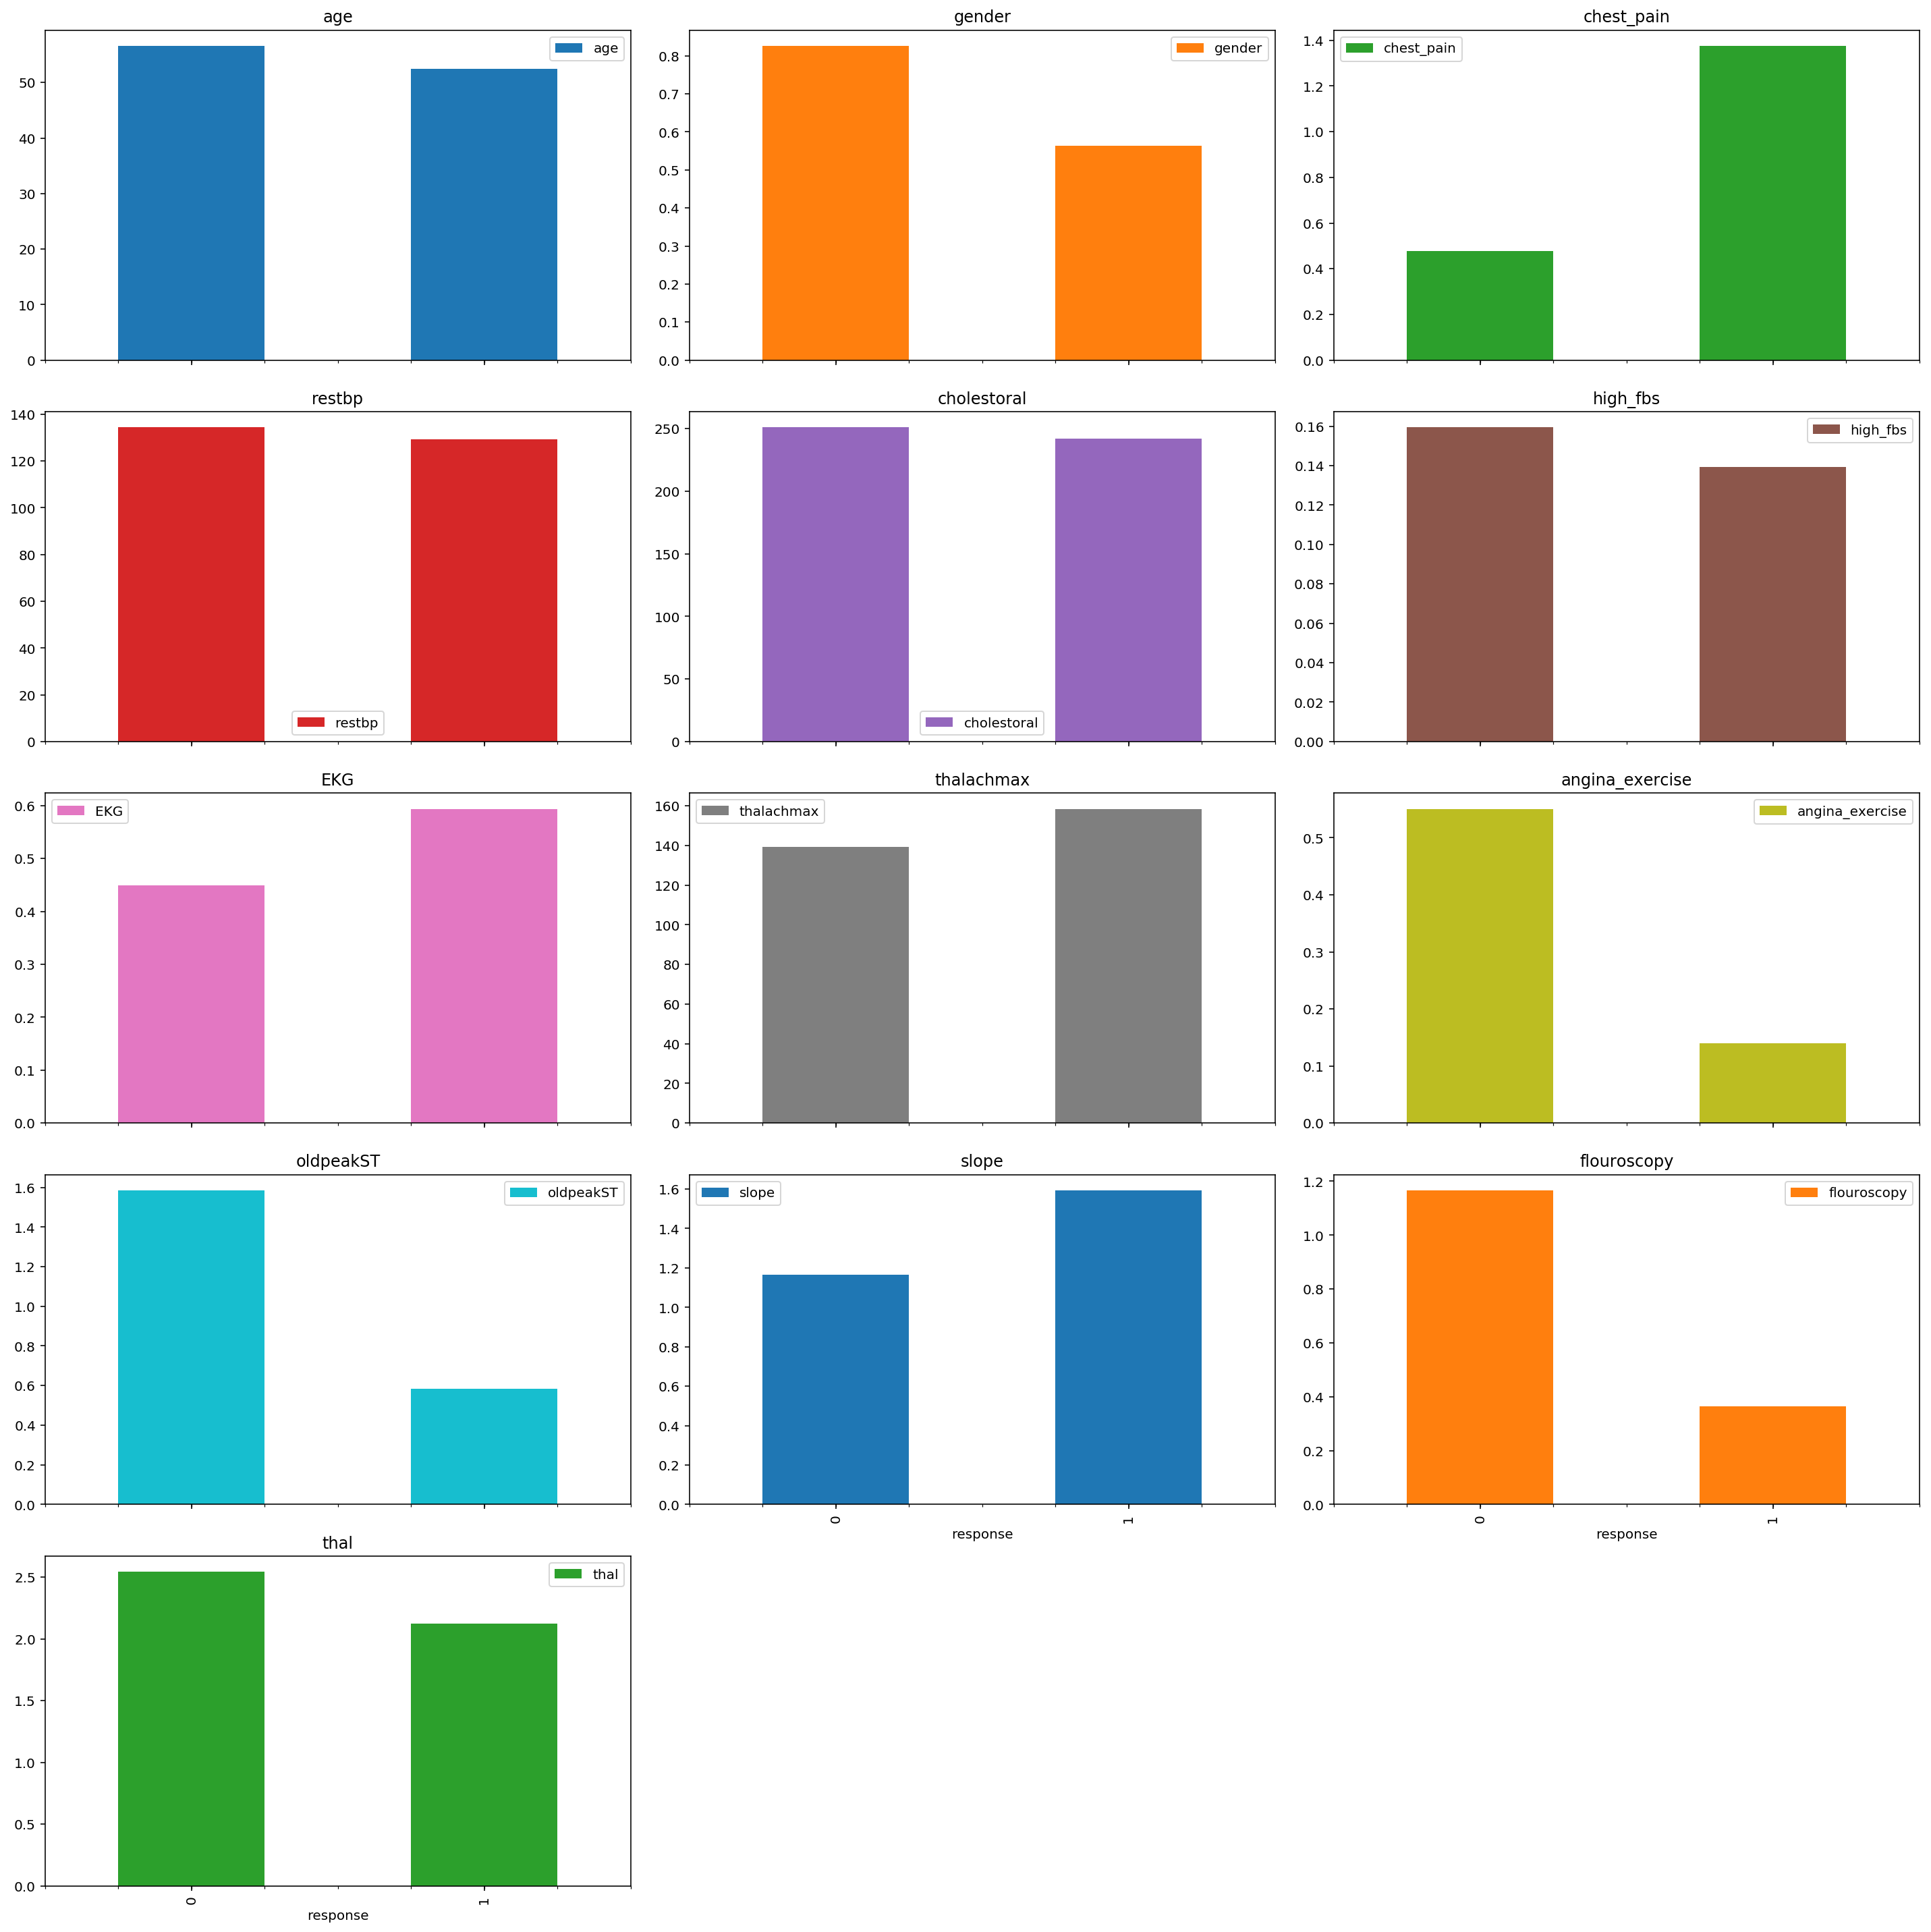

In [33]:
(raw_data
 .groupby('response')
 .mean()
 .plot(kind='bar', figsize=(20,20), subplots=True, layout=(5,3), sharex=True)
)
plt.tight_layout()

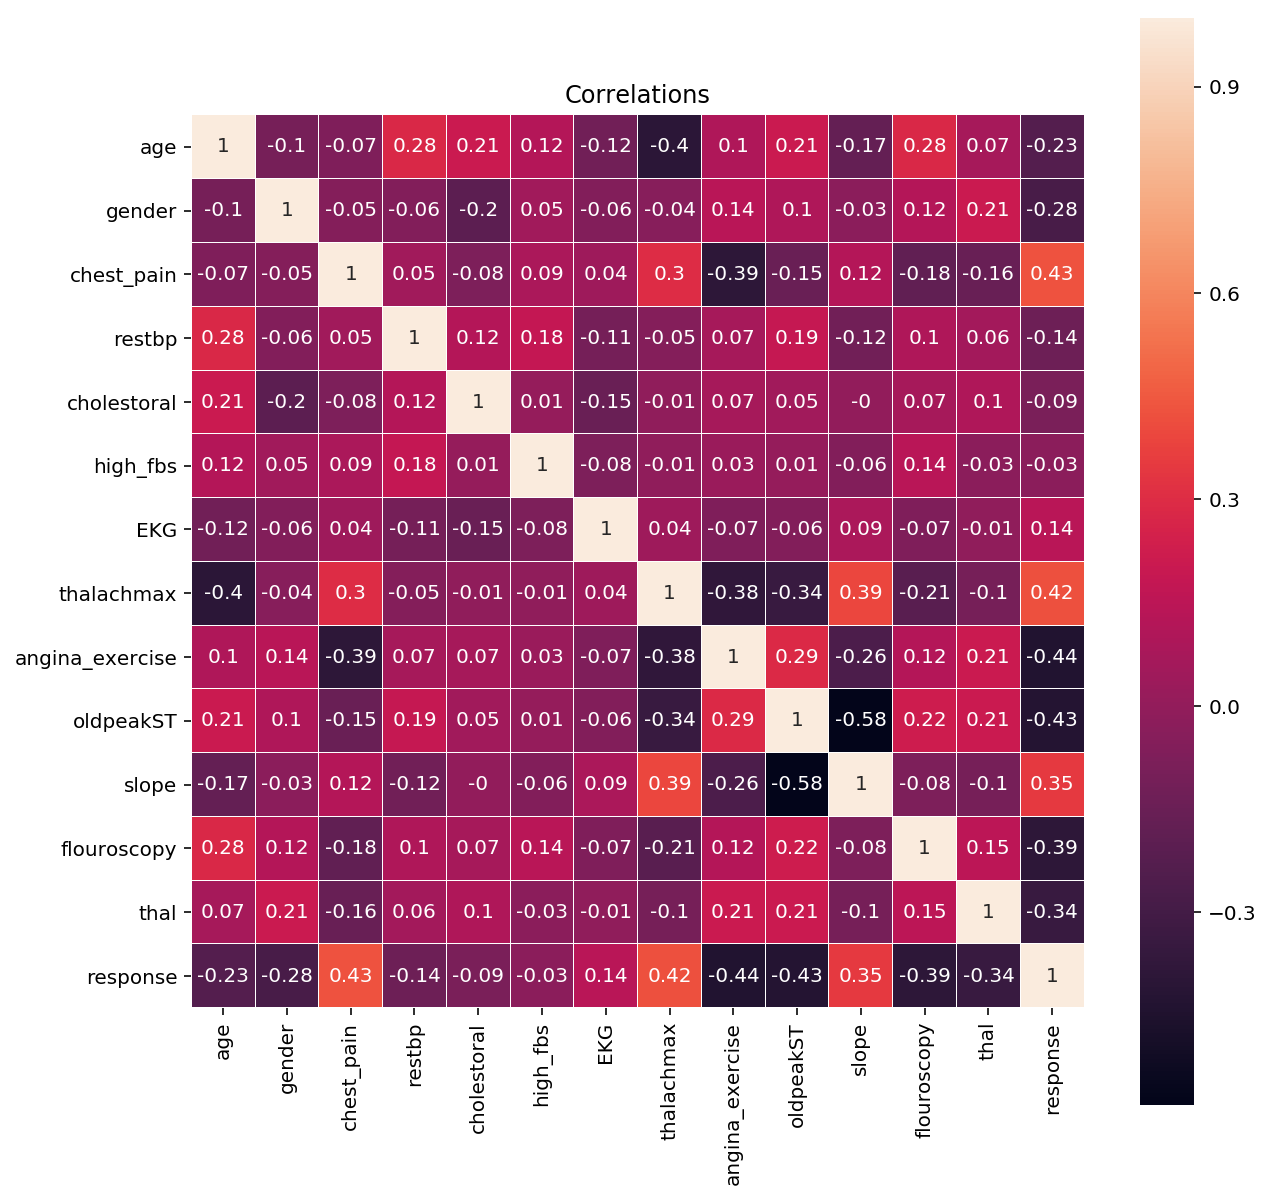

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(raw_data.corr().round(2), linewidths=0.01, annot=True, square=True)
plt.title('Correlations')
plt.show()

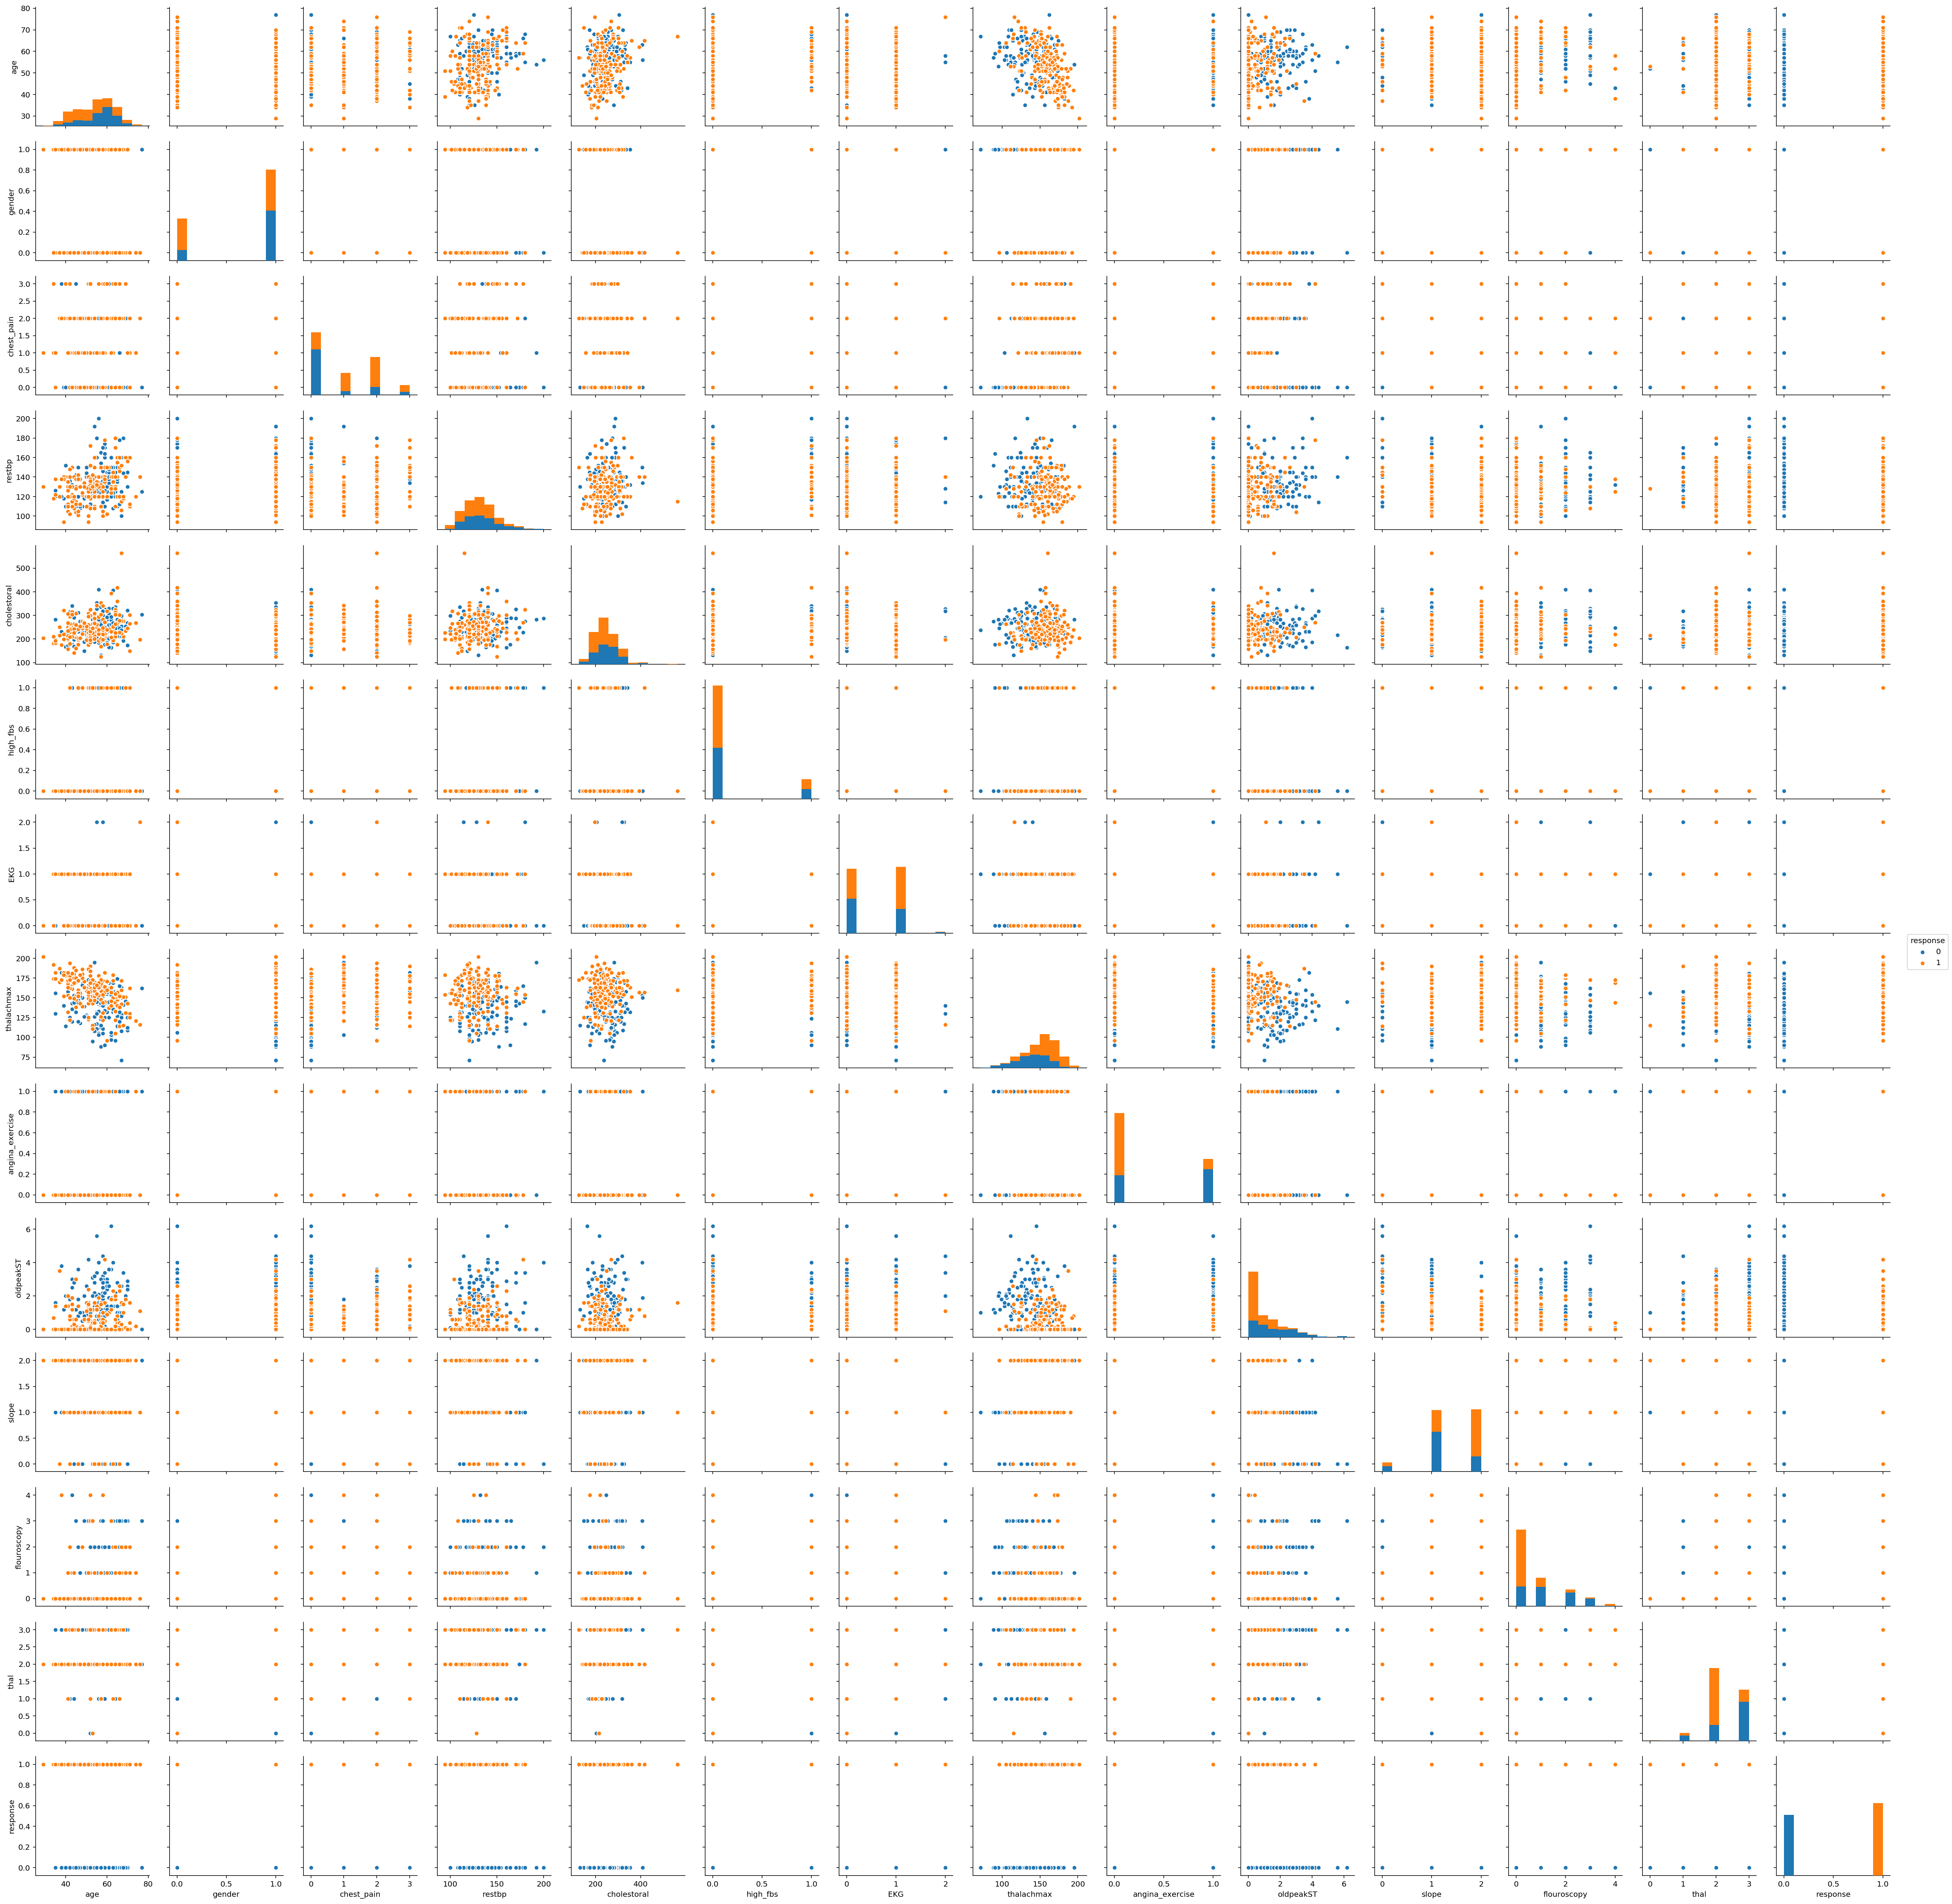

In [35]:
sns.pairplot(raw_data, hue='response')

### Setting up the model

In [9]:
y=raw_data['response']
feature_matrix=raw_data.drop(['response'], axis=1)
X = pd.get_dummies(feature_matrix, drop_first=True, dummy_na=True)
X.shape

(303, 13)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y.value_counts(normalize=True)

1    0.544554
0    0.455446
Name: response, dtype: float64

The baseline for this model is 54%.
We will start by using a Decision Tree model because we are interested in feature importance.

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.tree import DecisionTreeClassifier

dtc=DecisionTreeClassifier()
sc = StandardScaler()
X_scaled = pd.DataFrame(data=sc.fit_transform(X), columns=X.columns)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0.8524590163934426


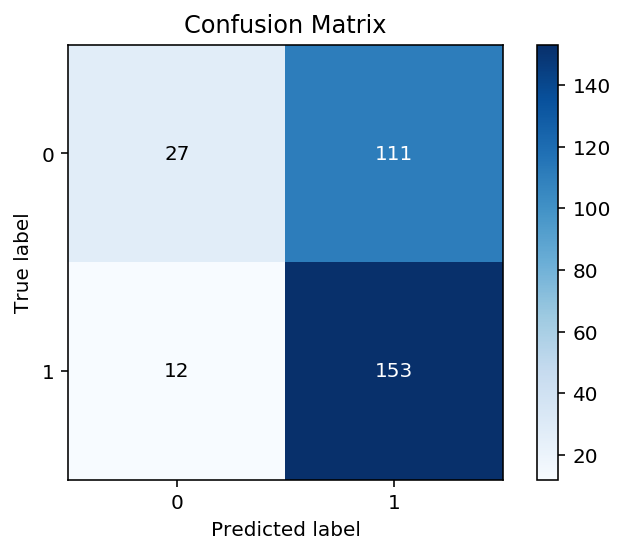

In [13]:
from scikitplot.metrics import plot_confusion_matrix

dtc.fit(X_train,y_train)
print(dtc.score(X_test,y_test))
y_pred=dtc.predict(X_scaled)
plot_confusion_matrix(y, y_pred)

In [14]:
feature_importance=pd.DataFrame(dtc.feature_importances_,
                               index=X_train.columns,
                               columns=['importance']).sort_values('importance')

In [15]:
feature_importance

,importance
high_fbs,0.000000
EKG,0.016097
thal,0.025328
gender,0.041015
restbp,0.057994
thalachmax,0.058893
slope,0.059530
angina_exercise,0.075421
oldpeakST,0.092402
age,0.100892


This model gives us an accuracy that is well above baseline. We have also extracted the feature importance, which includes chest pain, flouroscopy scores, age and cholesterol, who's importance was also reflected in the EDA figures.

However, the number of false positives is high. Althought this is preferable to a low recall in the context of patient health, it would be better to improve the true positive rate so as to lower overall cost.

At the same time, the number of false negatives is very low, which is very good in in a medical context. 

We will try to improve both the true-positive rate and true-negative rates.

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold

model = Pipeline([
    ('vt', VarianceThreshold(.1)),
    ('mm', MinMaxScaler()),
    ('model', RandomForestClassifier(n_estimators=200))
])

model.fit(X_train, y_train)
score = model.score(X_test, y_test)

print(f'Accuracy {round(score*100, 1)}%')

Accuracy 86.9%


In [17]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = dict(
    vt__threshold = np.linspace(0,.5, 3),
    model__max_depth = [1,2,4,8],
    model__min_samples_split = [4,8,16]
)

gs = GridSearchCV(model, param_grid, cv=3, n_jobs=1)

In [18]:
#We check a subset for a faster Grid Search
gs.fit(X_train.head(), y_train.head())

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vt', VarianceThreshold(threshold=0.1)), ('mm', MinMaxScaler(copy=True, feature_range=(0, 1))), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, m...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'vt__threshold': array([0.  , 0.25, 0.5 ]), 'model__max_depth': [1, 2, 4, 8], 'model__min_samples_split': [4, 8, 16]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [29]:
#Now we check the full data set with the best 5 params
best_params = pd.DataFrame(gs.cv_results_).sort_values(by='mean_test_score').tail(5)['params'].values

best_params

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py

array([{'model__max_depth': 1, 'model__min_samples_split': 16, 'vt__threshold': 0.25},
       {'model__max_depth': 2, 'model__min_samples_split': 8, 'vt__threshold': 0.5},
       {'model__max_depth': 2, 'model__min_samples_split': 8, 'vt__threshold': 0.25},
       {'model__max_depth': 4, 'model__min_samples_split': 16, 'vt__threshold': 0.25},
       {'model__max_depth': 2, 'model__min_samples_split': 16, 'vt__threshold': 0.5}],
      dtype=object)

Accuracy 84.2%


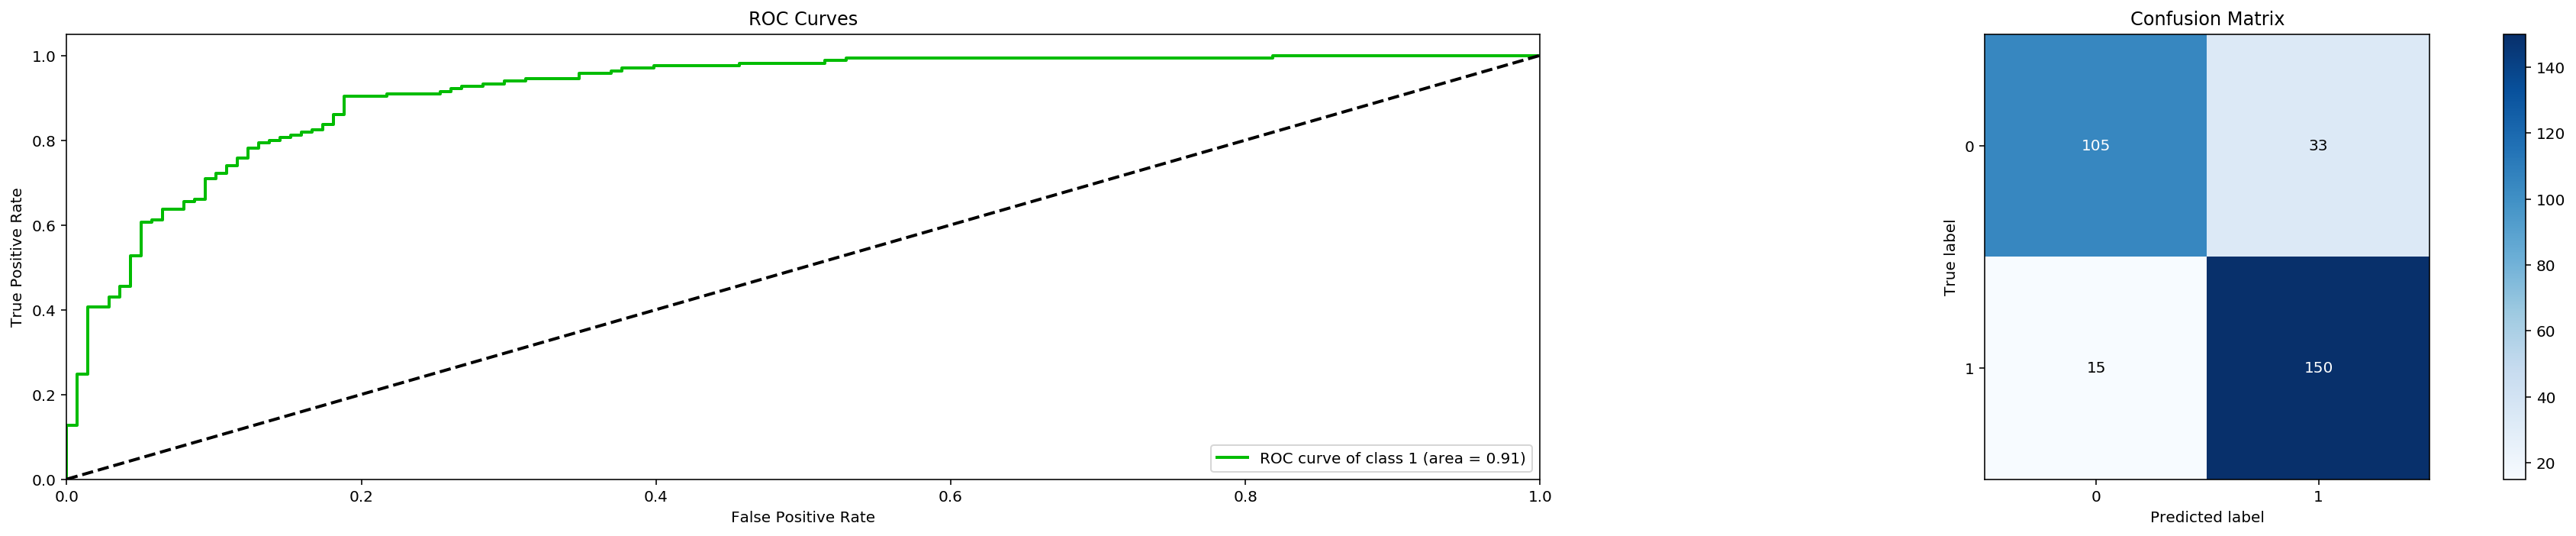

In [90]:
from sklearn.metrics import accuracy_score
from scikitplot.metrics import plot_roc, plot_precision_recall

model.set_params(**best_params[-3])

y_pred = cross_val_predict(model, X_scaled, y, method='predict', cv=5)
y_pred_proba = cross_val_predict(model, X_scaled, y, method='predict_proba', cv=5)

print(f'Accuracy {round(accuracy_score(y, y_pred)*100, 1)}%')

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(25,5)


plot_roc(y, y_pred_proba, plot_micro=False, plot_macro=False, classes_to_plot=1, ax=axes[0])
plot_confusion_matrix(y, y_pred, ax=axes[1])


plt.tight_layout()

In [64]:
from sklearn.metrics import classification_report

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.74      0.80       138
           1       0.81      0.92      0.86       165

   micro avg       0.83      0.83      0.83       303
   macro avg       0.84      0.83      0.83       303
weighted avg       0.84      0.83      0.83       303



At 92% recall, we have appropiatly identified the great majority of people who have heart disease. However, we could engage in a dialogue to set an appropiate threshold, trading more false positives for a higher recall.

Below, we are "flagging as ill" anyone who the model is 30%+ confident should see a doctor, which gives as a 99% recall.

In [72]:
thresh = .3
print(classification_report(y, y_pred_proba[:, 1]>thresh))

              precision    recall  f1-score   support

           0       0.98      0.38      0.54       138
           1       0.66      0.99      0.79       165

   micro avg       0.71      0.71      0.71       303
   macro avg       0.82      0.69      0.67       303
weighted avg       0.80      0.71      0.68       303

